In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [154]:
data = pd.read_csv(
    "customer_segmentation_project.zip", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [155]:
data['InvoiceDate'] = data['InvoiceDate'].astype('datetime64[ns]')
data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [156]:
print(f"Минимальное кол-во заказов: {data['UnitPrice'].describe().loc['min']}")

Минимальное кол-во заказов: -11062.06


In [157]:
print(f"Минимальное кол-во заказов: {data['Quantity'].describe().loc['min']}")
print(f"Максимальное кол-во заказов: {data['Quantity'].describe().loc['max']}")
print(f"Уникальных клиентов: {data['CustomerID'].describe().loc['unique']}")
print(f"Уникальных стран: {data['Country'].describe().loc['unique'] - 1}")
print(f"Самый популярные товар: {data['StockCode'].describe().loc['top']}")
print(f"Всего пропусков в данных: {data.isna().sum().sum()}")
print(f"Строк до удаления пропусков: {data.shape[0]}")
data = data.dropna(axis=0)
print(f"Строк после удаления пропусков: {data.shape[0]}")
print(f"Строк до удаления дублей: {data.shape[0]}")
data = data.drop_duplicates()
print(f"Строк после удаления дублей: {data.shape[0]}")

Минимальное кол-во заказов: -80995.0
Максимальное кол-во заказов: 80995.0
Уникальных клиентов: 4372
Уникальных стран: 37
Самый популярные товар: 85123A
Всего пропусков в данных: 136534
Строк до удаления пропусков: 541909
Строк после удаления пропусков: 406829
Строк до удаления дублей: 406829
Строк после удаления дублей: 401604


In [158]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


In [159]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
...,...,...,...
22185,18283,579673,50
22186,18283,580872,50
22187,18287,554065,29
22188,18287,570715,38


In [160]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x[0] == 'C' else 0)
round(nb_products_per_basket['order_canceled'].value_counts()[1] / nb_products_per_basket.shape[0] *100)

16

In [161]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


In [162]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


In [163]:
nb_products_per_basket[nb_products_per_basket['order_canceled'] == 1]

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1
...,...,...,...,...
22159,18274,C577832,11,1
22161,18276,C577386,1,1
22162,18276,C577390,1,1
22164,18277,C542086,1,1


In [164]:
nb_products_per_basket[nb_products_per_basket['order_canceled'] == 1].shape[0] == data[data['Quantity'] < 0].shape[0]

False

In [165]:
data[data['InvoiceNo'].str.contains('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


In [166]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
quantity_canceled

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
541904    0.0
541905    0.0
541906    0.0
541907    0.0
541908    0.0
Length: 401604, dtype: float64

In [167]:
data['QuantityCanceled'] = quantity_canceled
data = data[data['Quantity'] > 0]
data = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True) == False]
data = data[data['UnitPrice'] != 0]
data.shape

(391150, 9)

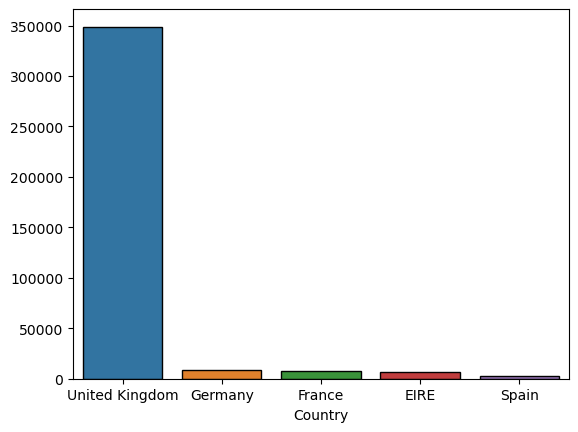

In [168]:
# Топ-5 стран по количеству заказов
plot_df = data.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)
sns.barplot(x=plot_df[:5].index, y=plot_df[:5].values);

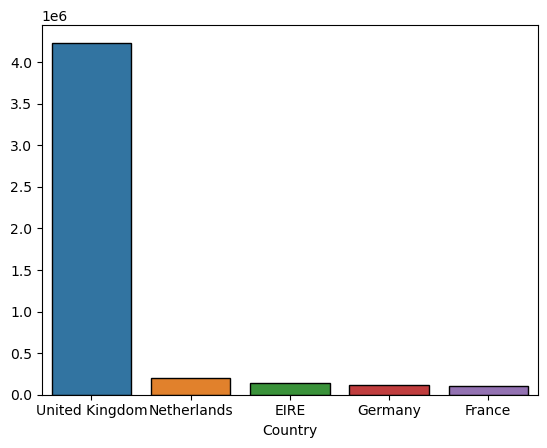

In [169]:
# Топ-5 стран по количеству товаров
plot_df = data.groupby('Country')['Quantity'].sum().sort_values(ascending=False)
sns.barplot(x=plot_df[:5].index, y=plot_df[:5].values);

In [170]:
#общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])
print(f"Средняя общая стоимость заказа: {round(data['TotalPrice'].mean())} £")

Средняя общая стоимость заказа: 21 £


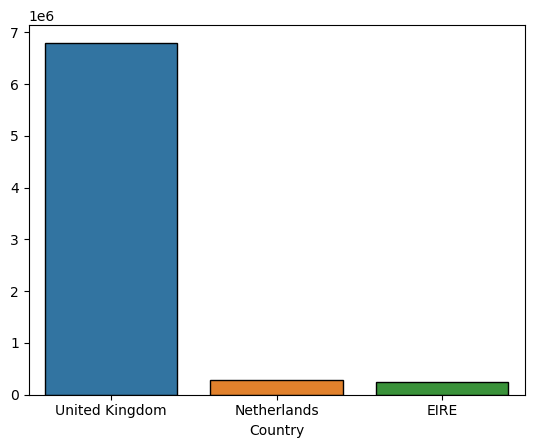

In [171]:
# Топ-3 страны по выручке
plot_df = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
sns.barplot(x=plot_df[:3].index, y=plot_df[:3].values);

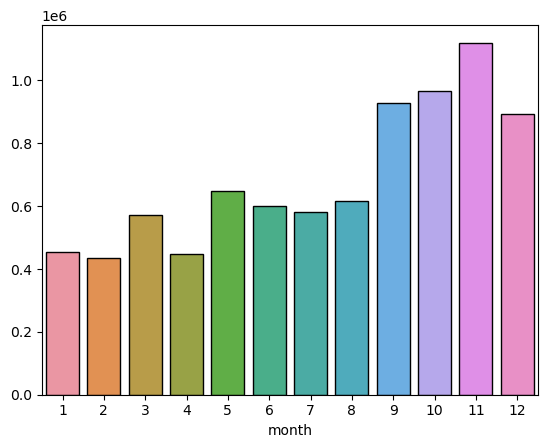

In [172]:
data['month'] = data['InvoiceDate'].dt.month
data['day_of_week'] = data['InvoiceDate'].dt.day_of_week
data['hour'] = data['InvoiceDate'].dt.hour
plot_df = data.groupby('month')['TotalPrice'].sum().sort_values(ascending=False)
sns.barplot(x=plot_df.index, y=plot_df.values);

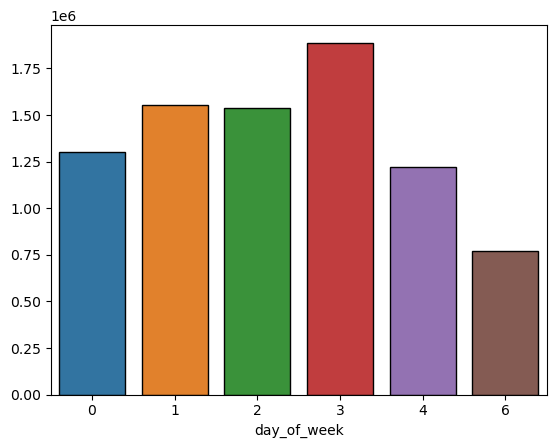

In [173]:
plot_df = data.groupby('day_of_week')['TotalPrice'].sum().sort_values(ascending=False)
sns.barplot(x=plot_df.index, y=plot_df.values);

<Axes: xlabel='hour', ylabel='date'>

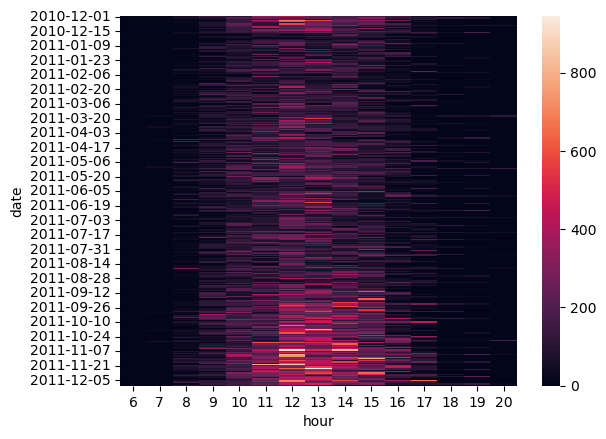

In [174]:
# HeatMap по датам и часам заказов (посчитаем количества заказанных товаров)
data['date'] = data['InvoiceDate'].dt.date
plot_df = data.pivot_table(
    values='Quantity',
    index='date',
    columns='hour',
    aggfunc='count',
    fill_value=0)

sns.heatmap(plot_df)

In [189]:
recency_data = data.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_data['Recency'] = pd.to_datetime('2011-12-10') - recency_data['InvoiceDate']
recency_data['Recency'] = recency_data['Recency'].dt.days
rfm_table = pd.DataFrame({
    'Recently':recency_data['Recency'].values,
    'Frequency':data.groupby('CustomerID')['InvoiceNo'].nunique(),
    'Monetary':data.groupby('CustomerID')['TotalPrice'].sum()
})

print(f"Клиенты совершившие заказ более 200 дней назад: {rfm_table[rfm_table['Recently'] > 200].shape[0]}")
print(f"Среднее количество заказов в год: {round(rfm_table['Frequency'].mean())}")
print(f"Сумма покупок клиента №12360: {round(rfm_table.loc['12360'][2])}")

Клиенты совершившие заказ более 200 дней назад: 743
Среднее количество заказов в год: 4
Сумма покупок клиента №12360: 2302


In [190]:
f_bound = np.quantile(rfm_table['Frequency'], 0.95)
m_bound = np.quantile(rfm_table['Monetary'], 0.95)
rfm_table_cleaned = rfm_table[~((rfm_table['Frequency'] > f_bound) | (rfm_table['Monetary'] > m_bound))]
print(rfm_table_cleaned.shape[0])

4044
